# Population structure - PCA of the FarGen cohort

In [1]:
import hail as hl
hl.init(spark_conf={'spark.driver.memory': '100g'}, tmp_dir='/home/olavur/tmp')

2021-11-04 12:21:43 WARN  NativeCodeLoader:62 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


2021-11-04 12:21:44 WARN  Hail:37 - This Hail JAR was compiled for Spark 2.4.5, running with Spark 2.4.1.
  Compatibility is not guaranteed.
2021-11-04 12:21:45 WARN  Utils:66 - Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
2021-11-04 12:21:45 WARN  Utils:66 - Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


Running on Apache Spark version 2.4.1
SparkUI available at http://hms-beagle-6676655f87-9xllv:4042
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.61-3c86d3ba497a
LOGGING: writing to /home/olavur/experiments/2020-11-13_fargen1_exome_analysis/fargen-1-exome/notebooks/main/hail-20211104-1221-0.2.61-3c86d3ba497a.log


In [2]:
from bokeh.io import show, output_notebook
from bokeh.layouts import gridplot
from bokeh.models.scales import LogScale
output_notebook()

Loading BokehJS ...

In [3]:
import pandas as pd
import numpy as np

## Load FarGen data

Use high-quality variants.

In [5]:
BASE_DIR = '/home/olavur/experiments/2020-11-13_fargen1_exome_analysis'
mt = hl.read_matrix_table(BASE_DIR + '/data/mt/high_quality_variants.mt')

In [5]:
n_variants, n_samples = mt.count()
print('Number of variants: ' + str(n_variants))
print('Number of samples: ' + str(n_samples))

Number of variants: 148305
Number of samples: 469


## Population filters

Update variants stats.

In [6]:
mt = hl.variant_qc(mt)

Remove variants with minor allele frequency under 0.01. Note that we remove only very rare variants, because common variants can be insufficient to describe fine-scale population structure at a subpopulation scale.

In [7]:
maf_filter = 0.01
mt = mt.filter_rows((mt.variant_qc.AF[1] > maf_filter) & (mt.variant_qc.AF[1] < (1 - maf_filter)))

## Filter indels

Remove all indels from the dataset.

In [8]:
mt = mt.filter_rows(hl.is_snp(mt.alleles[0], mt.alleles[1]))

## LD pruning

Before we calculate LD, we remove multi-allelic sites.

**NOTE:** I can do LD pruning on multi-allelic sites using [split_multi()](https://hail.is/docs/0.2/methods/genetics.html#hail.methods.split_multi).

In [9]:
# NOTE: Now that this dataset is split, it should be possible to do LD pruning without removing multi-allelic sites.
#mt = mt.filter_rows(hl.len(mt.alleles) == 2)

Prune variants with $r^2 > 0.2$ within a 500 000 basepair window.

**NOTE:** this $r^2$ value is quite arbitrary. It is the default from the Hail method and I did not try other values.

In [10]:
pruned_variant_table = hl.ld_prune(mt.GT, r2=0.2, bp_window_size=500000)
mt = mt.filter_rows(hl.is_defined(pruned_variant_table[mt.row_key]))

2021-10-27 13:02:53 Hail: INFO: ld_prune: running local pruning stage with max queue size of 399458 variants
[Stage 0:=====================================================>   (35 + 2) / 37]2021-10-27 13:03:00 Hail: INFO: wrote table with 47302 rows in 37 partitions to /home/olavur/tmp/qAToq8B6Exl6aEcqKTnKUB
    Total size: 1.44 MiB
    * Rows: 1.44 MiB
    * Globals: 11.00 B
    * Smallest partition: 655 rows (21.18 KiB)
    * Largest partition:  1513 rows (47.13 KiB)
[Stage 2:====================================================>    (11 + 1) / 12]2021-10-27 13:03:06 Hail: INFO: Wrote all 12 blocks of 47302 x 469 matrix with block size 4096.
[Stage 6:======================================================>  (22 + 1) / 23]2021-10-27 13:04:05 Hail: INFO: wrote table with 58 rows in 23 partitions to /home/olavur/tmp/kbtN3AoF3nBWkCoAIRxG1t
    Total size: 653.15 KiB
    * Rows: 1.92 KiB
    * Globals: 651.24 KiB
    * Smallest partition: 0 rows (21.00 B)
    * Largest partition:  10 rows (26

Make a checkpoint, caching all operations done on the matrix table.

In [11]:
if True:
    mt = mt.checkpoint('/home/olavur/tmp/ld_pruned.ht', overwrite=True)
else:
    mt = hl.read_matrix_table('/home/olavur/tmp/ld_pruned.ht')

[Stage 10:=============================================>          (30 + 7) / 37]2021-10-27 13:04:11 Hail: INFO: wrote matrix table with 47253 rows and 469 columns in 37 partitions to /home/olavur/tmp/ld_pruned.ht
    Total size: 282.87 MiB
    * Rows/entries: 282.82 MiB
    * Columns: 52.33 KiB
    * Globals: 11.00 B
    * Smallest partition: 655 rows (3.40 MiB)
    * Largest partition:  1516 rows (9.25 MiB)


In [12]:
n_variants, n_samples = mt.count()
print('Number of variants: ' + str(n_variants))
print('Number of samples: ' + str(n_samples))

Number of variants: 47253
Number of samples: 469


This may be a lot of variants to run a PCA analysis on, but as mentioned previously, we do not want to remove too many rare variants as these can hold a lot of information about fine-scale population structure.

## Annotate birth place region

Import data containing the birthplace ID of all FarGen participants. We will annotate the matrix table with these IDs.

First we read a table containing the birthplace but with the 'RIN' participant ID. We will have to map this 'RIN' ID to an 'FN' ID.

In [13]:
rin_birthplace_ht = hl.import_table(BASE_DIR + '/data/metadata/birthplace/rin_region.csv', delimiter=',')
# Rename "ind" to "rin".
# Convert the region variable to float.
rin_birthplace_ht = rin_birthplace_ht.transmute(rin=rin_birthplace_ht.ind, birthplace=hl.float64(rin_birthplace_ht.region))

rin_birthplace_ht = rin_birthplace_ht.key_by(rin_birthplace_ht.rin)

2021-10-27 13:04:11 Hail: INFO: Reading table without type imputation
  Loading field 'ind' as type str (not specified)
  Loading field 'region' as type str (not specified)


Import table with 'RIN' IDs and corresponding 'FN' IDs.

In [14]:
fargen_rin_ht = hl.import_table(BASE_DIR + '/data/metadata/birthplace/fargen_rin_samplename.csv', delimiter=',')
fargen_rin_ht = fargen_rin_ht.key_by(fargen_rin_ht.rin)

2021-10-27 13:04:11 Hail: WARN: Name collision: field 'sample' already in object dict. 
  This field must be referenced with __getitem__ syntax: obj['sample']
2021-10-27 13:04:11 Hail: INFO: Reading table without type imputation
  Loading field 'rin' as type str (not specified)
  Loading field 'sample' as type str (not specified)


Make a table with 'RIN', 'FN' and birthplace.

In [15]:
# Annotate the table with the birthplace by the samplenames.
samplename_birthplace_ht = rin_birthplace_ht.annotate(samplename=fargen_rin_ht[rin_birthplace_ht.rin].sample)
samplename_birthplace_ht = samplename_birthplace_ht.key_by(samplename_birthplace_ht.samplename)

We will now replace these region ID integers with the abbreviations below. For example, the abbreviation "NOR" corresponds to the Northern Islands (Norðuroyggjar) and the integer 1.

Region number | Region name(s) | Region abbreviation
-----|-----|----
1 | Norðoyggjar | <span style="color:#157EBF">NOR</span>
2 | Eysturoy og Norðstreymoy | <span style="color:#78B430">EYN</span>
3 | Suðurstreymoy | <span style="color:#FAA530">STR</span>
4 | Vágar og Mykines | <span style="color:#00E9E8">VAG</span>
5 | Sandoy, Skúvoy, Stóra Dímun | <span style="color:#FFF73F">SAN</span>
6 | Suðuroy | <span style="color:#974C93">SUD</span>

In [16]:
samplename_birthplace_ht = samplename_birthplace_ht.annotate_globals(region_names=['NOR', 'EYN', 'STR', 'VAG', 'SAN', 'SUD'])
# We subtract one from the integer ID to obtain zero based indexing.
samplename_birthplace_ht = samplename_birthplace_ht.annotate(birthplace_name=samplename_birthplace_ht.region_names[hl.int(samplename_birthplace_ht.birthplace) - 1])

Finally, we an annotate the matrix table with birthplace of samples.

In [17]:
mt = mt.annotate_cols(birthplace = samplename_birthplace_ht[mt.s].birthplace_name)

Count the number of samples in each region. Note that `birthplace=6` means that we do not know the birthplace of the sample.

In [18]:
cols_ht = mt.cols()
result = (cols_ht.group_by(cols_ht.birthplace)
    .aggregate(count = hl.agg.count()))
result.to_pandas()

2021-10-27 13:04:12 Hail: WARN: cols(): Resulting column table is sorted by 'col_key'.
    To preserve matrix table column order, first unkey columns with 'key_cols_by()'
2021-10-27 13:04:12 Hail: WARN: Name collision: field 'count' already in object dict. 
  This field must be referenced with __getitem__ syntax: obj['count']
2021-10-27 13:04:12 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-10-27 13:04:12 Hail: INFO: Ordering unsorted dataset with network shuffle
[Stage 15:>                                                         (0 + 1) / 1]2021-10-27 13:04:15 Hail: INFO: Ordering unsorted dataset with network shuffle


,birthplace,count
0,EYN,99
1,NOR,69
2,SAN,17
3,STR,178
4,SUD,34
5,VAG,28
6,None,44


## Filter related individuals

Estimate the relatedness between the samples by the PC-Relate method, with a minimum alternate allele frequency of 0.001.

In [19]:
pc_rel = hl.pc_relate(mt.GT, 0.001, k=2, statistics='kin')

[Stage 21:==========================>                            (18 + 19) / 37]2021-10-27 13:04:18 Hail: INFO: hwe_normalized_pca: running PCA using 47253 variants.
[Stage 22:======================================================> (36 + 1) / 37]2021-10-27 13:04:20 Hail: INFO: pca: running PCA with 2 components...
[Stage 466:====>                                                  (1 + 11) / 12]2021-10-27 13:04:52 Hail: INFO: Wrote all 12 blocks of 47253 x 469 matrix with block size 4096.


Plot all the relatedness coefficients in a histogram to get an overview.

In [20]:
p = hl.plot.histogram(pc_rel.kin, title='Histogram of kinship coefficient')
show(p)

2021-10-27 13:04:52 Hail: INFO: wrote matrix with 3 rows and 47253 columns as 12 blocks of size 4096 to /home/olavur/tmp/pcrelate-write-read-c4XDZHa29kM9MWnN21R2w5.bm
2021-10-27 13:04:53 Hail: INFO: wrote matrix with 47253 rows and 469 columns as 12 blocks of size 4096 to /home/olavur/tmp/pcrelate-write-read-ZO0AHU5EP4sOsVUwu1EQLV.bm
[Stage 469:>                                                        (0 + 1) / 1]2021-10-27 13:05:09 Hail: INFO: wrote matrix with 469 rows and 469 columns as 1 block of size 4096 to /home/olavur/tmp/pcrelate-write-read-u6sQ5Q2MYyD6i3QfrzGUTy.bm
[Stage 470:>                                                        (0 + 1) / 1]2021-10-27 13:05:26 Hail: INFO: wrote matrix with 469 rows and 469 columns as 1 block of size 4096 to /home/olavur/tmp/pcrelate-write-read-GPkcvE0E7c15efnRZrgPLO.bm
2021-10-27 13:05:26 Hail: INFO: wrote matrix with 469 rows and 469 columns as 1 block of size 4096 to /home/olavur/tmp/pcrelate-write-read-wQtYpshWw0hZkjBj6ADQJl.bm
2021-10-2

In [21]:
pairs = pc_rel.filter(pc_rel['kin'] > 2**(-4))

Then we find the maximal independent set, consistent of the samples to remove.

In [22]:
related_samples_to_remove = hl.maximal_independent_set(pairs.i, pairs.j, keep=False)

2021-10-27 13:06:01 Hail: INFO: wrote matrix with 3 rows and 47253 columns as 12 blocks of size 4096 to /home/olavur/tmp/pcrelate-write-read-v983vyHTgfdqpEq06z7VdO.bm
2021-10-27 13:06:01 Hail: INFO: wrote matrix with 47253 rows and 469 columns as 12 blocks of size 4096 to /home/olavur/tmp/pcrelate-write-read-v4LnbuAzGGYHqw9evjZbVK.bm
[Stage 485:>                                                        (0 + 1) / 1]2021-10-27 13:06:16 Hail: INFO: wrote matrix with 469 rows and 469 columns as 1 block of size 4096 to /home/olavur/tmp/pcrelate-write-read-XYTdy3DruLvZPaRzJSc1W2.bm
[Stage 486:>                                                        (0 + 1) / 1]2021-10-27 13:06:32 Hail: INFO: wrote matrix with 469 rows and 469 columns as 1 block of size 4096 to /home/olavur/tmp/pcrelate-write-read-n8xZHCqEhUHLjMtO77kU4q.bm
2021-10-27 13:06:32 Hail: INFO: wrote matrix with 469 rows and 469 columns as 1 block of size 4096 to /home/olavur/tmp/pcrelate-write-read-mG9V4AdMZDkgcbPuR8lgC3.bm
2021-10-2

Now we filter these individuals from the matrix table.

In [23]:
mt = mt.filter_cols(hl.is_defined(related_samples_to_remove[mt.col_key]), keep=False)

Make a checkpoint, caching all operations done on the matrix table.

In [4]:
if False:
    mt = mt.checkpoint('/home/olavur/tmp/rel_pruned.ht', overwrite=True)
else:
    mt = hl.read_matrix_table('/home/olavur/tmp/rel_pruned.ht')

In [5]:
n_variants, n_samples = mt.count()
print('Number of variants: ' + str(n_variants))
print('Number of samples: ' + str(n_samples))

Number of variants: 47253
Number of samples: 382


## Compute PCA

In [6]:
eigenvalues, scores, loadings = hl.hwe_normalized_pca(mt.GT, k=4)

[Stage 0:========================================>               (27 + 10) / 37]2021-11-04 12:22:41 Hail: INFO: hwe_normalized_pca: running PCA using 47253 variants.
[Stage 1:====>                                                    (3 + 25) / 37]2021-11-04 12:22:43 Hail: INFO: pca: running PCA with 4 components...
[Stage 2:==============================>                         (20 + 17) / 37]

In [7]:
mt = mt.annotate_cols(scores = scores[mt.s].scores)

In [8]:
p = hl.plot.scatter(mt.scores[0],
                    mt.scores[1],
                    label=hl.str(mt.birthplace),
                    title='PCA', xlabel='PC1', ylabel='PC2')
p.plot_width = 800
p.plot_height = 600
show(p)

Above are the two first principal components plotted against eachother. Note that there are four outlier samples. These outliers may be due to the quality of these samples, so we shall invesigate them closer below.

As we see below, there seems to be nothing abnormal about these four samples. They may therefore potentially be *ancestry outliers*.

In [13]:
mt = mt.annotate_cols(pc_outliers = mt.scores[0] < -0.4)

In [14]:
exprs_list = [('# heterozygotes', mt.sample_qc.n_het), ('Ti/Tv rate', mt.sample_qc.r_ti_tv), ('Call rate', mt.sample_qc.call_rate), ('# singletons', mt.sample_qc.n_singleton)]
plot_list = []
for name, exprs in exprs_list:
    p = hl.plot.scatter(mt.sample_qc.dp_stats.mean, exprs, label=mt.pc_outliers, xlabel='DP mean', ylabel=name, legend=True)
    p.plot_width = 800
    p.plot_height = 500
    plot_list.append(p)

In [15]:
show(gridplot(plot_list, ncols=2, plot_width=600, plot_height=400))

## Remove potential ancestry outliers from full dataset

In further analysis of the dataset, we do not want to include these four potential ancestry outliers (PAO). We will therefore load the full dataset, discard the PAOs, and write the data again.

In [32]:
# Potential ancestry outliers.
pao_list = mt.filter_cols(mt.pc_outliers).s.collect()

print('Number of potential ancestry outliers: {n}'.format(n=len(pao_list)))

Number of potential ancestry outliers: 4


In [33]:
# Read original matrix table.
full_mt = hl.read_matrix_table(BASE_DIR + '/data/mt/high_quality_variants.mt')

# Annotate with the list of potential ancestry outliers.
full_mt = full_mt.annotate_globals(pao_list = pao_list)

# Remove the potential ancestry outliers.
pao_removed_mt = full_mt.filter_cols(~full_mt.pao_list.contains(full_mt.s))

In [34]:
n_variants, n_samples = pao_removed_mt.count()
print('Number of variants: ' + str(n_variants))
print('Number of samples: ' + str(n_samples))

Number of variants: 148305
Number of samples: 465


Update variant QC information, as this has changed when we have removed some samples. Also remove invariant sites.

In [35]:
pao_removed_mt = hl.variant_qc(pao_removed_mt)

pao_removed_mt = pao_removed_mt.filter_rows(pao_removed_mt.variant_qc.AC[1] > 0)

In [36]:
n_variants, n_samples = pao_removed_mt.count()
print('Number of variants: ' + str(n_variants))
print('Number of samples: ' + str(n_samples))

[Stage 740:=====================================>                (26 + 11) / 37]

Number of variants: 148267
Number of samples: 465


Write the resulting matrix table to file.

In [37]:
if True:
    pao_removed_mt.write(BASE_DIR + '/data/mt/high_quality_variants_pao_removed.mt', overwrite=True)

[Stage 741:===============================================>       (32 + 5) / 37]2021-10-27 13:10:15 Hail: INFO: wrote matrix table with 148267 rows and 465 columns in 37 partitions to /home/olavur/experiments/2020-11-13_fargen1_exome_analysis/data/mt/high_quality_variants_pao_removed.mt
    Total size: 808.14 MiB
    * Rows/entries: 808.09 MiB
    * Columns: 49.46 KiB
    * Globals: 39.00 B
    * Smallest partition: 1506 rows (6.70 MiB)
    * Largest partition:  4487 rows (25.24 MiB)


## PCA without outliers

These PCA outerliers prevent us from detecting population structure in the PCA above. Whether they are ancestry outliers or whether something else is at play, we must remove them to be able to detect population structure.

In [16]:
mt = mt.filter_cols(~mt.pc_outliers)

Compute PCA again.

Note that we keep all the components, so that we can calculate percent variance explained.

In [17]:
eigenvalues, scores, loadings = hl.hwe_normalized_pca(mt.GT, k=mt.count_cols())

2021-11-04 12:29:45 Hail: INFO: hwe_normalized_pca: running PCA using 47253 variants.
2021-11-04 12:29:46 Hail: INFO: pca: running PCA with 378 components...


Calculate the proportion of variance explained by each component.

In [18]:
prop_var = np.array(eigenvalues) / sum(eigenvalues)

Annotate the matrix table with the PCA scores.

In [19]:
mt = mt.annotate_cols(scores = scores[mt.s].scores)

In [20]:
pc_idx1 = 0
pc_idx2 = 1
p = hl.plot.scatter(mt.scores[pc_idx1],
                    mt.scores[pc_idx2],
                    label=hl.str(mt.birthplace),
                    title='PCA', xlabel='PC{n} ({p:.2f}%)'.format(n=pc_idx1+1, p=prop_var[pc_idx1] * 100), ylabel='PC{n} ({p:.2f}%)'.format(n=pc_idx2+1, p=prop_var[pc_idx1] * 100))
p.plot_width = 800
p.plot_height = 600
show(p)

In [18]:
pc_idx1 = 0
pc_idx2 = 2
p = hl.plot.scatter(mt.scores[pc_idx1],
                    mt.scores[pc_idx2],
                    label=hl.str(mt.birthplace),
                    title='PCA', xlabel='PC{n} ({p:.2f}%)'.format(n=pc_idx1+1, p=prop_var[pc_idx1] * 100), ylabel='PC{n} ({p:.2f}%)'.format(n=pc_idx2+1, p=prop_var[pc_idx1] * 100))
p.plot_width = 800
p.plot_height = 600
show(p)

In [19]:
pc_idx1 = 1
pc_idx2 = 2
p = hl.plot.scatter(mt.scores[pc_idx1],
                    mt.scores[pc_idx2],
                    label=hl.str(mt.birthplace),
                    title='PCA', xlabel='PC{n} ({p:.2f}%)'.format(n=pc_idx1+1, p=prop_var[pc_idx1] * 100), ylabel='PC{n} ({p:.2f}%)'.format(n=pc_idx2+1, p=prop_var[pc_idx1] * 100))
p.plot_width = 800
p.plot_height = 600
show(p)

## Plot with seaborn

In [35]:
import seaborn as sns
from matplotlib import pyplot as plt

In [33]:
cols_ht = mt.cols()
cols_ht = cols_ht.annotate(pc1 = cols_ht.scores[0], pc2 = cols_ht.scores[1], pc3 = cols_ht.scores[2])
temp_pd = cols_ht.select('birthplace', 'pc1', 'pc2', 'pc3').to_pandas()

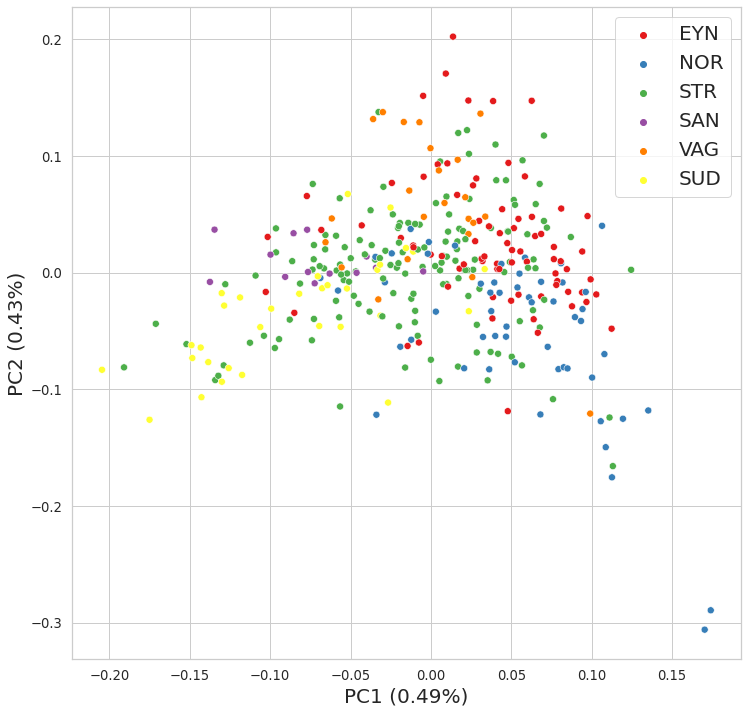

In [52]:
fig, ax = plt.subplots(figsize=(12, 12))

sns.set_theme(style='whitegrid', font_scale=1.2)

g = sns.scatterplot(
    data=temp_pd, x='pc1', y='pc2', hue='birthplace',
    ax=ax, s=50, palette='Set1'
)

_ = ax.legend(prop={'size': 20})
_ = ax.set_xlabel('PC{n} ({p:.2f}%)'.format(n=1, p=prop_var[0] * 100), fontsize=20)
_ = ax.set_ylabel('PC{n} ({p:.2f}%)'.format(n=2, p=prop_var[1] * 100), fontsize=20)

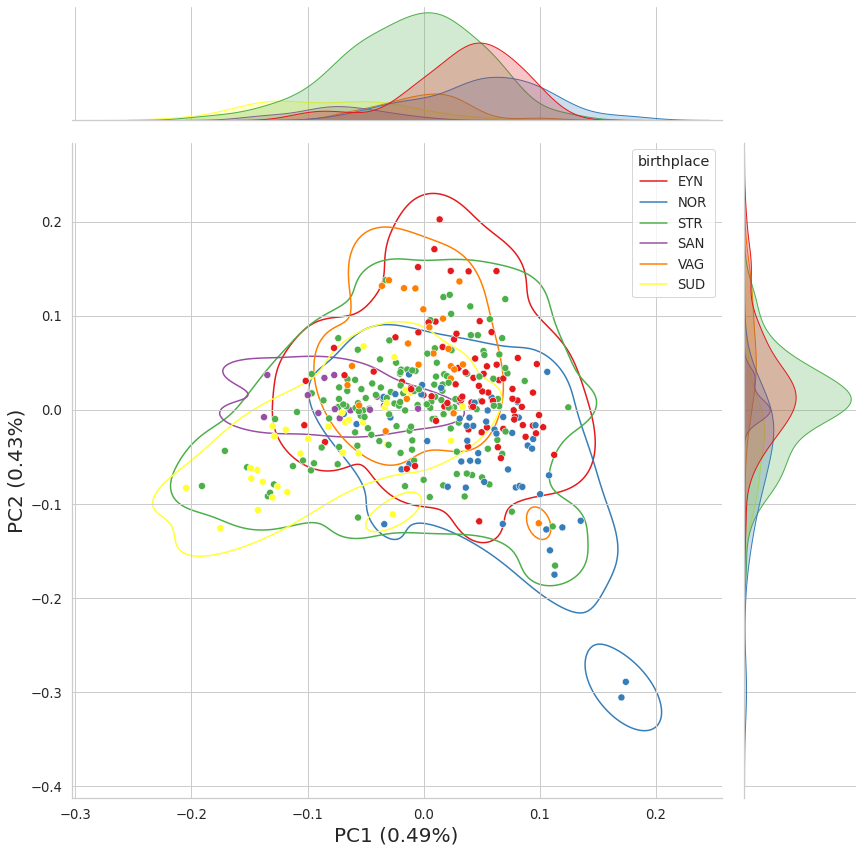

In [87]:
sns.set_theme(style='whitegrid', font_scale=1.2)

g = sns.jointplot(
    data=temp_pd, x='pc1', y='pc2', hue='birthplace', s=50, palette='Set1', height=12
)

g = g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=1)

fig = g.figure
ax = fig.axes

_ = ax[0].set_xlabel('PC{n} ({p:.2f}%)'.format(n=1, p=prop_var[0] * 100), fontsize=20)
_ = ax[0].set_ylabel('PC{n} ({p:.2f}%)'.format(n=2, p=prop_var[1] * 100), fontsize=20)

In [89]:
fig = g.figure
fig.savefig(BASE_DIR + '/data/figures/pca_fargen.png', format='png', dpi=400)

### Proportion of variance explained by PCA

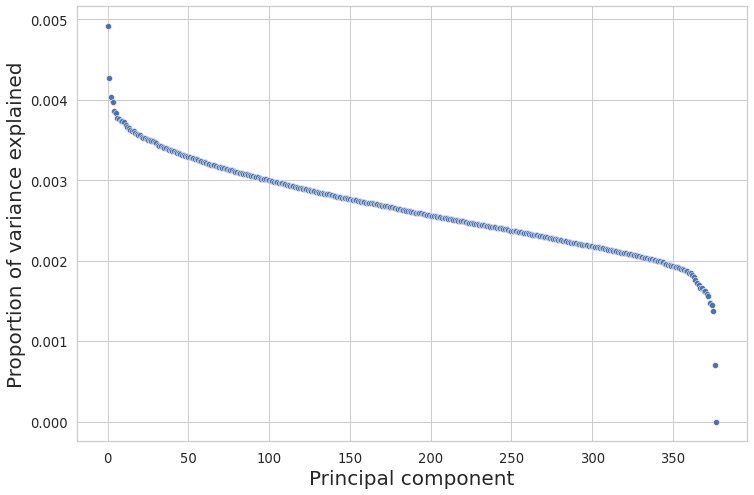

In [38]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.set_theme(style='whitegrid', font_scale=1.2)


g = sns.scatterplot(data=prop_var)

_ = ax.set_ylabel('Proportion of variance explained', fontsize=20)
_ = ax.set_xlabel('Principal component', fontsize=20)

From this PCA, it looks like there is very little population structure. But I'm not so convinced, I see this as a failure to detect population structure, not a success to show that there is no population structure.

## Summary

In this notebook we have:

* Investigate population structure in the cohort
* Removed potential ancestry outliers from the data